# Skellam-NMF: experiments
This notebook has been developped in order to generate all figures and results that can be found section IV *Experimental Studies* of [1]
It can be executed using python 3.8.5 and the following packages:
- cupy 8.6.0 (optional, for gpu backend)
- wonterfact 3.0.0
- scikit-learn 0.24.2
- xarray 0.18.2
- pymf3 0.3* (updated version to be found here https://github.com/benoit-fuentes/pymf3)
- unlzw3 0.2.1
- matplotlib 3.3.1
- seaborn 0.10.1

Warning, the running of this notebook can take hours, even days.

References : [1] B.Fuentes and G.Richard, "*Probabilistic semi-nonnegative matrix factorization: a Skellam-based framework*", submitted to IEEE TPAMI
***


In [1]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import numpy as np
import numpy.random as npr
import scipy.special as scs
import wonterfact.examples.snmf as wtf_snmf
import wonterfact.utils as wtfu
import xarray as xr
import sklearn.metrics
import pymf
import requests
from itertools import product, permutations
from pathlib import Path
import unlzw3
import tempfile
try:
    import cupy as cp
    xp = cp
    wtf.glob.set_backend_processor('gpu', force=True)
except:
    xp = np
print("Wonterfact will run on {}".format(wtf.glob.processor))

Wonterfact will run on gpu


***
## Parameter estimation on synthetic data

In [2]:
# Definition of necessary functions

def generetate_synthetic_data(
    uncertainty_level='low', # 'low' or 'high'
    low_variance=False,
    dim_i=3,
    dim_j=5000,
    dim_k=2,
    seed_hyperparam=None,
    seed_param=None,
):
    """
    Generates synthetic data
    """
    # defining hyperparameters
    npr.seed(seed_hyperparam)
    shape_kis = npr.uniform(size=(dim_k, dim_i, 2))
    if uncertainty_level == 'low':
        shape_kis = 1 + 10 * shape_kis
        shape_k = np.array([5., 50., 20., 2., 4., 100.])[:dim_k]
    elif uncertainty_level == 'high':
        shape_kis = 0.5 + shape_kis * 0.5
        shape_k = np.array([.8, .5, .9, .6, .7, .95])[:dim_k]
    if low_variance:
        for kk, ii in product(range(dim_k), range(dim_i)):
            shape_kis[kk, ii, shape_kis[kk, ii].argmin()] = 0.02
    mean_gamma = 100
    rate_k = shape_k / mean_gamma / dim_i
    
    #defining parameters
    npr.seed(seed_param)
    theta_kis = np.zeros_like(shape_kis)
    lambda_jk = npr.gamma(shape=np.ones((dim_j, dim_k)) * shape_k, scale=np.ones((dim_j, dim_k)) / rate_k)
    for kk in range(dim_k):
        theta_kis[kk] = npr.dirichlet(shape_kis[kk].ravel()).reshape((dim_i, 2))
    lambda_jis = np.einsum('jk,kis->jis', lambda_jk, theta_kis, )
    obs_ji = npr.poisson(lambda_jis[..., 0]) - npr.poisson(lambda_jis[..., 1])
    return obs_ji, shape_kis, shape_k, rate_k, theta_kis, lambda_jk

def make_one_run(
    uncertainty_level,  # 'low' or 'high'
    low_variance,  # bool
    inference_mode,
    seed_hyperparam,
    seed_param=0,
    n_iter=2000
):
    obs_ji, shape_kis, shape_k, rate_k, theta_kis, lambda_jk = generetate_synthetic_data(
        uncertainty_level=uncertainty_level,
        low_variance=low_variance,
        dim_i=3,
        dim_j=5000,
        dim_k=2,
        seed_hyperparam=seed_hyperparam,
        seed_param=seed_param
    )
    atoms_nonneg_init = shape_kis / shape_kis.sum((1, 2))
    activations_init = np.zeros_like(lambda_jk) + shape_k / (1 + rate_k)
    tree = wtf_snmf.make_snmf(
        obs_ji,
        atoms_nonneg_init,
        activations_init,
        fix_atoms=False,
        atoms_shape_prior=shape_kis,
        activations_shape_prior=shape_k,
        activations_rate_prior=rate_k,
        inference_mode=inference_mode,
        integer_data=True,
    )
    if inference_mode == 'VBEM':
        # necessary to change init_type for VBEM so posterior_shape = prior_shape 
        # for initialization
        tree.atoms.init_type = 'prior'
        tree.activations.init_type = 'prior'
    tree.estimate_param(n_iter)
    return tree, theta_kis, lambda_jk

def extract_factors(tree):
    """
    Returns atoms and activations estimates from a wonterfact tree
    """
    if tree.inference_mode == 'EM':
        atoms = tree.atoms.tensor_as_numpy
        activations = tree.activations.tensor_as_numpy
    elif tree.inference_mode == 'VBEM':
        atoms = tree.atoms.get_posterior_shape(force_numpy=True)
        atoms = atoms / atoms.sum(tree.atoms.norm_axis, keepdims=True)
        activations = tree.activations.get_posterior_shape(force_numpy=True) / tree.activations.get_posterior_rate(force_numpy=True)
    return atoms, activations

def compute_mse_mean_var(atoms_true, atoms_estim, activations_true, activations_estim):
    """
    Compute mse_m and mse_v
    """
    atoms_real_true = atoms_true[..., 0] - atoms_true[..., 1]
    atoms_real_estim = atoms_estim[..., 0] - atoms_estim[..., 1]
    atoms_var_true = atoms_true[..., 0] + atoms_true[..., 1]
    atoms_var_estim = atoms_estim[..., 0] + atoms_estim[..., 1]
    mean_source_true = np.einsum('jk,ki->jki', activations_true, atoms_real_true)
    mean_source_estim = np.einsum('jk,ki->jki', activations_estim, atoms_real_estim)
    var_source_true = np.einsum('jk,ki->jki', activations_true, atoms_var_true)
    var_source_estim = np.einsum('jk,ki->jki', activations_estim, atoms_var_estim)
    return ((mean_source_true - mean_source_estim)**2).mean(), ((var_source_true-var_source_estim)**2).mean()

In [3]:
# Instantiate or load the results xarray

result_filename = "SNMF_parameter_metrics.nc"
if not Path(result_filename).exists():
    uncertainty_level_list = ['low', 'high']
    low_variance_list = [False, True]
    seed_hyperparam_list = [0, 10, 138]
    seed_param_list = np.arange(50)
    algorithm_list = [
        "Dummy",
        "EM",
        "VBEM",
    ]
    metric_list = ['mse_mean', 'mse_var']
    result_arr = xr.DataArray(
        data=np.ones(
            (len(uncertainty_level_list), len(low_variance_list), len(seed_hyperparam_list), len(seed_param_list), len(algorithm_list), len(metric_list))
        ) * np.nan,
        dims=("uncertainty_level", "low_variance", "seed_hyperparam", "seed_param", "algorithm", "metric"),
        coords={
            "uncertainty_level": uncertainty_level_list,
            "low_variance": low_variance_list,
            "seed_hyperparam": seed_hyperparam_list,
            "seed_param": seed_param_list,
            "algorithm": algorithm_list,
            "metric": metric_list
        },
        name="metrics"
    )
    result_arr.to_netcdf(result_filename)

########################################
result_arr = xr.load_dataarray(result_filename)


In [4]:
# run experiment
for uncertainty_level, low_variance, seed_hyperparam, seed_param, algorithm in product(
        result_arr['uncertainty_level'].values,
        result_arr['low_variance'].values,
        result_arr['seed_hyperparam'].values,
        result_arr['seed_param'].values,
        result_arr['algorithm'].values
    ):
        access = dict(
            uncertainty_level=uncertainty_level, low_variance=low_variance,
            seed_hyperparam=seed_hyperparam, seed_param=seed_param,
            algorithm=algorithm
        )
        nb_iteration = 0
        if np.isnan(result_arr.loc[access].values).any():
            if algorithm == "Dummy":
                obs_ji, shape_kis, shape_k, rate_k, theta_kis, lambda_jk = generetate_synthetic_data(
                    uncertainty_level=uncertainty_level,
                    low_variance=low_variance,
                    dim_i=3,
                    dim_j=5000,
                    dim_k=2,
                    seed_hyperparam=seed_hyperparam,
                    seed_param=seed_param
                )
                atoms_estim = shape_kis / shape_kis.sum((1, 2), keepdims=True)
                activations_estim = np.zeros_like(lambda_jk) + shape_k / rate_k
            else:
                tree, theta_kis, lambda_jk  = make_one_run(
                    uncertainty_level=uncertainty_level,
                    low_variance=low_variance,
                    inference_mode=algorithm,
                    seed_hyperparam=seed_hyperparam,
                    seed_param=seed_param,
                    n_iter=10000
                )
                nb_iteration = tree.current_iter
                atoms_estim, activations_estim = extract_factors(tree)   
            mse_mean, mse_var = compute_mse_mean_var(theta_kis, atoms_estim, lambda_jk, activations_estim)
            result_arr.loc[{**access, **{"metric": 'mse_mean'}}] = mse_mean
            result_arr.loc[{**access, **{"metric": 'mse_var'}}] = mse_var
            result_arr.to_netcdf(result_filename)

            with np.printoptions(precision=2):
                print(list(access.values()),  result_arr.loc[access].values, "nb iter:{}".format(nb_iteration))
                

In [5]:
# Plot the results
mean_res = ((result_arr.sel(seed_hyperparam=10)).mean(('seed_param')) * 10**-3).round(2).transpose('metric', 'algorithm', 'uncertainty_level', 'low_variance')
std_res = ((result_arr.sel(seed_hyperparam=10)).std(('seed_param')) * 10**-3).round(2).transpose('metric', 'algorithm', 'uncertainty_level', 'low_variance')
mean_res = mean_res.values.reshape((2,3,4))
std_res = std_res.values.reshape((2,3,4))
print_arr = np.empty(mean_res.shape, dtype=object)
for ii, jj, kk in product(range(2), range(3), range(4)):
    print_arr[ii, jj, kk] = "{}|{}".format(mean_res[ii, jj, kk], std_res[ii, jj, kk])
print("Content of Table 3 of the article:")
print(print_arr)

Content of Table 3 of the article:
[[['1.01|0.54' '1.95|0.52' '15.74|6.76' '31.57|8.33']
  ['0.66|0.49' '0.18|0.03' '5.99|12.25' '0.73|0.97']
  ['0.9|0.68' '0.12|0.03' '6.63|13.23' '0.57|1.34']]

 [['1.75|0.36' '1.98|0.51' '25.42|5.77' '32.63|7.27']
  ['3.09|2.31' '0.2|0.06' '13.79|13.36' '1.38|2.0']
  ['2.84|2.35' '0.13|0.06' '13.45|12.79' '1.43|3.43']]]


***
## Online hyperparameter estimation on synthetic data

In [6]:
# Definitions of functions

def get_result_dataset(seed_hyperparam):
    """
    Loads of create a new result dataset
    """
    param_filename = "SNMF_hyperparam_estim_records_{}.nc".format(seed_hyperparam)
    try:
        result_ds = xr.load_dataset(param_filename)
    except FileNotFoundError:
        nb_run, dim_k, dim_i, dim_s = 2000, 2, 3, 2
        result_ds = xr.Dataset(
            data_vars=dict(
                atoms_estim=(['r', 'k', 'i', 's'], np.ones((nb_run, dim_k, dim_i, dim_s)) * np.nan),
                atoms_shape_estim=(['r', 'k', 'i', 's'], np.ones((nb_run, dim_k, dim_i, dim_s)) * np.nan),
                atoms_shape_update_estim=(['r', 'k', 'i', 's'], np.ones((nb_run, dim_k, dim_i, dim_s)) * np.nan),
                activations_rate_estim=(['r', 'k'], np.ones((nb_run, dim_k)) * np.nan),
                activations_rate_update_estim=(['r', 'k'], np.ones((nb_run, dim_k)) * np.nan),
                activations_shape_estim=(['r', 'k'], np.ones((nb_run, dim_k)) * np.nan),
                activations_shape_update_estim=(['r', 'k'], np.ones((nb_run, dim_k)) * np.nan),
                atoms_true=(['r', 'k', 'i', 's'], np.ones((nb_run, dim_k, dim_i, dim_s)) * np.nan),
                atoms_shape_true=(['k', 'i', 's'], np.ones((dim_k, dim_i, dim_s)) * np.nan),
                activations_rate_true=(['k', ], np.ones((dim_k)) * np.nan),
                activations_shape_true=(['k', ], np.ones((dim_k)) * np.nan),
                atoms_shape_mse=(['r', ], np.ones(nb_run) * np.nan),
                activations_rate_mse=(['r', ], np.ones(nb_run) * np.nan),
                activations_shape_mse=(['r', ], np.ones(nb_run) * np.nan),
                mse_mean=(['r', ], np.ones(nb_run) * np.nan),
                mse_var=(['r', ], np.ones(nb_run) * np.nan),
                permutation=(['r', ], -1 * np.ones(nb_run, dtype=int)),
            ),
            attrs=dict(
                description="Results and metrics for one run of hyperparameter online estimation",
                seed_hyperparam=seed_hyperparam,
                seed_param_init=seed_param_init
            )
        )
        result_ds.to_netcdf(param_filename)
    return result_ds, param_filename

def reset_result_dataset(result_dataset):
    for data in result_dataset.data_vars.values():
        data[...] = np.nan if data.dtype==float else -1

def set_tree_on_new_data(
    uncertainty_level,
    low_variance,
    seed_hyperparam,
    seed_param=None,
    atoms_shape_prior=None,
    activations_shape_prior=None,
    activations_rate_prior=None,
    tree=None
):
    obs_ji, shape_kis, shape_k, rate_k, theta_kis, lambda_jk = generetate_synthetic_data(
        uncertainty_level=uncertainty_level,
        low_variance=low_variance,
        dim_i=3,
        dim_j=5000,
        dim_k=2,
        seed_hyperparam=seed_hyperparam,
        seed_param=seed_param
    )
    if tree is None:
        atoms_nonneg_init = np.ones_like(theta_kis)
        activations_init = np.ones_like(lambda_jk)
        tree = wtf_snmf.make_snmf(
            obs_ji,
            atoms_nonneg_init,
            activations_init,
            fix_atoms=False,
            atoms_shape_prior=atoms_shape_prior,
            activations_shape_prior=activations_shape_prior,
            activations_rate_prior=activations_rate_prior,
            inference_mode='VBEM',
            integer_data=True,
        )
        tree.atoms.init_type = 'prior'  # prior hyperparameters should define the initialization
        tree.activations.init_type = 'prior'  # idem
    else:
        tree.observer.tensor[...] = xp.array(obs_ji)
        tree.reset()
    tree.verbose_iter = 0
    return tree, shape_kis, shape_k, rate_k, theta_kis, lambda_jk

def component_best_permute(theta_kis, lambda_jk, tree):
    dim_k = lambda_jk.shape[1]
    lambda_jkis_true = np.einsum('jk,kis->jkis', lambda_jk, theta_kis)
    lambda_jkis_estim = np.einsum('jk,kis->jkis', tree.activations.tensor_as_numpy, tree.atoms.tensor_as_numpy)
    all_perm = list(permutations(range(dim_k)))
    argmin = np.array(
        [
            ((lambda_jkis_true[:, perm] - lambda_jkis_estim) ** 2).sum() for perm in all_perm
        ]
    ).argmin()
    return all_perm[argmin]

In [7]:
# definition of constants 
dim_k, dim_i, dim_s = 2, 3, 2
uncertainty_level = 'low'
low_variance = True

for seed_hyperparam in [0, 4, 26, 55, 123]:  # random seeds, only seed=123 is showed in the article
    seed_param_init = seed_hyperparam * 10

    result_dataset, param_filename = get_result_dataset(seed_hyperparam)
    # reset_dataset(result_dataset)

    # hyperparam initialization
    npr.seed(126)  # for reproductible research
    atoms_shape_prior = 1 + 1e-5 * npr.rand(dim_k, dim_i, dim_s)
    activations_shape_prior = np.ones(dim_k)
    activations_rate_prior = 0.001 * np.ones(dim_k)
    tree = None

    # iterate on new data
    for ii in range(1300):
        tree, shape_kis, shape_k, rate_k, theta_kis, lambda_jk = set_tree_on_new_data(
            uncertainty_level,
            low_variance,
            seed_hyperparam=seed_hyperparam,
            seed_param=seed_param_init + ii,
            atoms_shape_prior=atoms_shape_prior,
            activations_shape_prior=activations_shape_prior,
            activations_rate_prior=activations_rate_prior,
            tree=tree
        )
        # estimate param
        if np.isnan(result_dataset['mse_var'][ii]).any():
            tree.estimate_param(15000)
            # update hyperparamters
            tree.estimate_hyperparam(100, learning_rate=0.02)
            atoms_estim, activations_estim = extract_factors(tree)
            # record data
            result_dataset['atoms_estim'][ii][...] = atoms_estim
            result_dataset['atoms_shape_estim'][ii][...] = tree.atoms_shape.tensor_as_numpy
            result_dataset['atoms_shape_update_estim'][ii][...] = tree.atoms_shape.getattr_as_numpy('tensor_update')
            result_dataset['activations_rate_estim'][ii][...] = tree.activations_rate.tensor_as_numpy
            result_dataset['activations_rate_update_estim'][ii][...] = tree.activations_rate.getattr_as_numpy('tensor_update')
            result_dataset['activations_shape_estim'][ii][...] = tree.activations_shape.tensor_as_numpy
            result_dataset['activations_shape_update_estim'][ii][...] = tree.activations_shape.getattr_as_numpy('tensor_update')
            result_dataset['atoms_true'][ii][...] = theta_kis
            result_dataset['atoms_shape_true'][...] = shape_kis
            result_dataset['activations_rate_true'][...] = rate_k
            result_dataset['activations_shape_true'][...] = shape_k
            result_dataset['permutation'][ii] = component_best_permute(theta_kis, lambda_jk, tree)[0]

            perm = (result_dataset['permutation'][ii].item(), 1 - result_dataset['permutation'][ii].item())
            result_dataset['atoms_shape_mse'][ii] = ((tree.atoms_shape.tensor_as_numpy - shape_kis[perm, ]) ** 2).mean()
            result_dataset['activations_rate_mse'][ii] = ((tree.activations_rate.tensor_as_numpy - rate_k[perm,]) ** 2).mean()
            result_dataset['activations_shape_mse'][ii] = ((tree.activations_shape.tensor_as_numpy - shape_k[perm,]) ** 2).mean()
            mse_mean, mse_var = compute_mse_mean_var(theta_kis[perm, ], atoms_estim, lambda_jk[..., perm], activations_estim)
            result_dataset['mse_mean'][ii] = mse_mean
            result_dataset['mse_var'][ii] = mse_var
            result_dataset.to_netcdf(param_filename)
            print(
                "iter:{}|nb_iter:{}|atm_sh_mse:{:.3e}|act_sh_mse:{:.3e}|act_rt_mse:{:.3e}|mse_mean:{:.3e}|act_sh:[{:.3e},{:.3e}]".format(
                    ii,
                    tree.current_iter,
                    result_dataset['atoms_shape_mse'][ii].item(),
                    result_dataset['activations_shape_mse'][ii].item(),
                    result_dataset['activations_rate_mse'][ii].item(),
                    result_dataset['mse_mean'][ii].item(),
                    tree.activations_shape.tensor_as_numpy[0],
                    tree.activations_shape.tensor_as_numpy[1],
                )
            )
        else:
            tree.estimate_param(1)
            tree.estimate_hyperparam(1, learning_rate=0.02)
            tree.atoms_shape.tensor[...] = xp.array(result_dataset['atoms_shape_estim'][ii])
            tree.atoms_shape.tensor_update[...] = xp.array(result_dataset['atoms_shape_update_estim'][ii])
            tree.activations_rate.tensor[...] = xp.array(result_dataset['activations_rate_estim'][ii])
            tree.activations_rate.tensor_update[...] = xp.array(result_dataset['activations_rate_update_estim'][ii])
            tree.activations_shape.tensor[...] = xp.array(result_dataset['activations_shape_estim'][ii])
            tree.activations_shape.tensor_update[...] = xp.array(result_dataset['activations_shape_update_estim'][ii])

In [8]:
# result_dataset = xr.load_dataset('SNMF_hyperparam_estim_records_0.nc')
# result_dataset = xr.load_dataset('SNMF_hyperparam_estim_records_4.nc')
# result_dataset = xr.load_dataset('SNMF_hyperparam_estim_records_26.nc')
# result_dataset = xr.load_dataset('SNMF_hyperparam_estim_records_55.nc')
result_dataset = xr.load_dataset('SNMF_hyperparam_estim_records_123.nc')


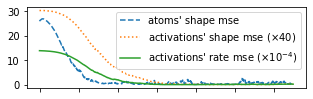

In [9]:
f, ax = plt.subplots(1, sharex=True, figsize=[5, 1.5])
ax.plot(result_dataset['atoms_shape_mse'][:1300], '--', label="atoms' shape mse")
ax.plot(result_dataset['activations_shape_mse'][:1300] / 40, ':', label="activations\' shape mse $(\\times 40)$")
ax.plot(result_dataset['activations_rate_mse'][:1300] * 1000, '-', label="activations\' rate mse $(\\times 10^{-4})$")
ax.legend()
# ax.set_ylabel('mse')
xticklabels = ax.set_xticklabels(())

(0.0, 1181.8705320433096)

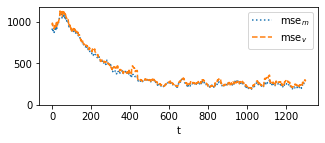

In [10]:
import scipy as sc
f, ax = plt.subplots(1, sharex=True, figsize=[5, 1.8])
cval = result_dataset['mse_mean'][:30].mean()
ax.plot(sc.ndimage.convolve1d(result_dataset['mse_mean'], np.ones(30)/30, mode='constant', cval= cval)[:1300], ':', label="mse$_m$")
cval = result_dataset['mse_var'][:30].mean()
ax.plot(sc.ndimage.convolve1d(result_dataset['mse_var'], np.ones(30)/30, mode='constant', cval= cval)[:1300], '--', label="mse$_v$")
ax.legend()
ax.set_xlabel('t')
ax.set_ylim(bottom=0)

***
## Difference between Sk$_1$ and Sk$_\infty$ for SNMF

In [11]:
def make_data():
    dim_k, dim_i, dim_j = 3, 10, 100
    atoms_real = npr.choice([-1, 1], size=[dim_k, dim_i]) * npr.dirichlet(
        np.ones(dim_i) * 0.9, size=dim_k
    )
    activations = npr.gamma(shape=0.6, scale=2, size=(dim_j, dim_k))
    data = np.einsum("jk,ki->ji", activations, atoms_real)
    data += npr.randn(dim_j, dim_i) * 1e-4
    return data, activations, atoms_real

def compute_mean_square_error(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

def run_snmf(data, atom_real, integer_data=False):
    dim_j, dim_i = data.shape
    dim_k, dim_i = atom_real.shape
    atoms_nonneg = wtfu.real_to_2D_nonnegative(atoms_real)
    tree = wtf_snmf.make_snmf(
        data=data,
        atoms_nonneg_init=atoms_nonneg,
        activations_init=np.ones((dim_j, dim_k)),
        fix_atoms=True,
        activations_rate_prior=0,
        integer_data=integer_data,
    )
    tree.update_type = 'regular'  # Disable parabolic EM
    tree.cost_computation_iter = 1  # Compute objective function at each iteration
    tree.stop_estim_threshold = 0  # Prevent EM algorithm to stop if convergence 
    tree.estimate_param(1000)
    return tree.activations.tensor_as_numpy, np.array(tree.cost_record)


In [12]:
data, activations, atoms_real = make_data()
activations_estim1, cost_record1 = run_snmf(data, atoms_real, integer_data=True)
activations_estim2, cost_record2 = run_snmf(data, atoms_real, integer_data=False)
mse1 = compute_mean_square_error(activations, activations_estim1)
mse2 = compute_mean_square_error(activations, activations_estim2)

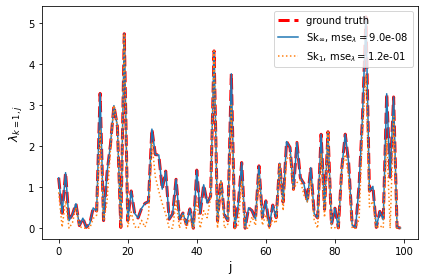

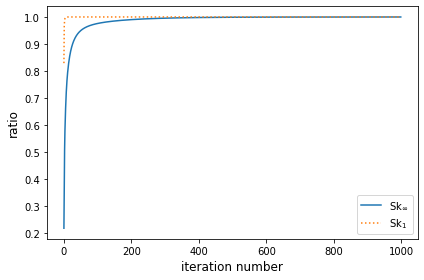

In [13]:
plt.figure()
plt.plot(activations[:,0], 'r--', linewidth=3, label="ground truth")
label = "Sk$_\infty$, mse$_{{\\lambda}}=${:.1e}".format(mse2)
plt.plot(activations_estim2[:,0], '-', label=label)
label = "Sk$_1$, mse$_{{\\lambda}}=${:.1e}".format(mse1)
plt.plot(activations_estim1[:,0], ':', label=label)
plt.legend()
plt.xlabel('j', fontsize=12)
plt.ylabel('$\lambda_{{k=1,j}}$', fontsize=12)
plt.tight_layout()
plt.figure()
label = "Sk$_\infty$"
plt.plot((abs(cost_record2[1:]) / abs(cost_record2[:-1])), '-', label=label)
label = "Sk$_1$"
plt.plot((abs(cost_record1[1:]) / abs(cost_record1[:-1])), ':', label=label)
plt.legend()
plt.xlabel('iteration number', fontsize=12)
plt.ylabel('ratio', fontsize=12)
plt.tight_layout()

INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode


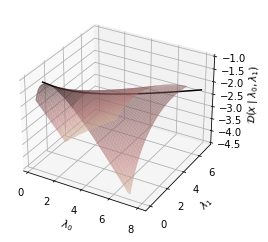

In [14]:
# Plot objective function of sk1

from mpl_toolkits.mplot3d import Axes3D

# Generate mesh
X1_init = np.concatenate((np.linspace(0.0001,.1,2000), np.linspace(.1,7,1000)))
X2_init = X1_init.copy()
X1, X2 = np.meshgrid(X1_init[2020:], X2_init[2020:])
Z = X1 + X2 - np.log(X1) - wtfu.hyp0f1ln(2 * np.ones(X1.shape), X1 * X2) + scs.loggamma(2)
mask = (Z > 4.5)
X1[mask] = np.nan
X2[mask] = np.nan

# Display the mesh
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.plot_surface(X1, X2, -Z, cmap = 'pink_r', alpha=0.6)

X1_init = 1 + X2_init
X1_comp = X2_init
Z_max = X1_init + X1_comp - np.log(X1_init) - wtfu.hyp0f1ln(2 * np.ones(X1_init.shape), X1_init * X1_comp) + scs.loggamma(2)
ax.plot(X1_init, X1_comp, - Z_max, color = 'k')

ax.set_xlabel('$\\lambda_0$')
ax.set_ylabel('$\\lambda_1$')
ax.set_zlabel('$\mathcal{D} (x \mid \\lambda_0, \\lambda_1) $')
ax.set_zlim(bottom=-4.5, top=-1)

plt.show()

INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode


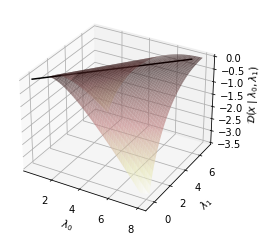

In [15]:
# Plot objective function of skinf

X1, X2 = np.meshgrid(X1_init[2020:], X2_init[2020:])
temp = (1 + 4 * X1 * X2) ** .5
Z = X1 + X2 - np.log(X1) - temp + np.log((1 + temp) / 2)
mask = (Z > 3.5)
X1[mask] = np.nan
X2[mask] = np.nan

# Display the mesh
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.plot_surface(X1, X2, -Z, cmap = 'pink_r', alpha=0.6)

ax.plot(np.array([0.5, 7.5]), np.array([-0.5, 6.5]), np.array([0, 0]), color = 'k')

ax.set_xlabel('$\\lambda_0$')
ax.set_ylabel('$\\lambda_1$')
ax.set_zlabel('$\mathcal{D} (x \mid \\lambda_0, \\lambda_1) $')
ax.set_zlim(bottom=-3.5, top=0)

plt.show()

***
## Automatic clustering on real data

In [16]:
#functions to dowload and load datasets

def download_dataset(url, filepath):
    dp = Path(filepath)
    dp.parent.mkdir(parents=True, exist_ok=True)
    req = requests.get(url, allow_redirects=True)
    open(filepath, 'wb').write(req.content)
    
def load_dataset(name):
    if name == "ionosphere":
        url = "http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
        filepath = "./data/ionosphere/ionosphere.data"
        if not Path(filepath).exists():
            download_dataset(url, filepath)
        data = np.genfromtxt(
            filepath,
            delimiter=',',
            usecols=range(34)
        )
        y_true = np.genfromtxt(
            filepath,
            delimiter=',',
            usecols=34,
            dtype=str,
            converters = {34: lambda s: (1 if s==b'g' else 0)}
        )
    elif name == 'wave':
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/waveform/waveform.data.Z'
        filepath = "./data/waveform/waveform.data"
        if not Path(filepath).exists():
            Path(filepath).parent.mkdir(parents=True, exist_ok=True)
            with tempfile.NamedTemporaryFile() as tempf:
                download_dataset(url, tempf.name)
                open(filepath, 'wb').write(unlzw3.unlzw(Path(tempf.name)))
        data = np.genfromtxt(
            filepath,
            delimiter=',',
        )
        y_true = data[:, -1].astype(int)
        data = data[:, :-1]
    elif name == "image":  # we concatenate data and test 
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.data"
        filepath1 = "./data/image/segmentation.data"
        if not Path(filepath1).exists():
            download_dataset(url, filepath1)
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.test"
        filepath2 = "./data/image/segmentation.test"
        if not Path(filepath2).exists():
            download_dataset(url, filepath2)
        data = np.concatenate(
            (
                np.genfromtxt(
                    filepath1,
                    delimiter=',',
                    skip_header=5,
                    usecols=range(1, 20)
                ),
                np.genfromtxt(
                    filepath2,
                    delimiter=',',
                    skip_header=5,
                    usecols=range(1, 20)
                )
            ), axis=0 
        )
        y_true = np.concatenate(
            (
                np.genfromtxt(
                    filepath1,
                    delimiter=',',
                    skip_header=5,
                    usecols=0,
                    dtype=str
                ),
                np.genfromtxt(
                    filepath2,
                    delimiter=',',
                    skip_header=5,
                    usecols=0,
                    dtype=str
                )
            ), axis=0
        )
        class_list = list(set(y_true))
        y_true = np.array([class_list.index(class_name) for class_name in y_true])
    elif name == "shuttle":  # only testing data, since training data is too big
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/shuttle/shuttle.tst"
        filepath = "./data/shuttle/shuttle.tst"
        if not Path(filepath).exists():
            download_dataset(url, filepath)
        data = np.concatenate(
            (
                np.genfromtxt(
                    filepath,
                    delimiter=' ',
                ),
            ), axis=0
        )
        y_true = data[:, -1].astype(int)
        data = data[:, :-1]
    return data, y_true

In [17]:
def get_accuracy(y_true, y_estim):
    class_number = len(set(y_true))
    conf_mat = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    acc = max(
        conf_mat[:, perm].trace() for perm in permutations(range(class_number))
    )
    return acc
def get_skellam_snmf_y_pred(
    data, class_number, inference_mode, n_iter=2000
):
    dim_j, dim_i = data.shape
    tree = wtf_snmf.make_snmf(
        data=data,
        atoms_nonneg_init=npr.rand(class_number, dim_i, 2),
        activations_init=np.ones((dim_j, class_number)),
        inference_mode=inference_mode,
    )
    tree.estimate_param(n_iter)
    print("{} iterations".format(tree.current_iter))
    return tree.activations.tensor_as_numpy.argmax(1)
def get_y_pred(data, class_number, algo, n_iter=200):
    if algo == "Ding":
        snmf = pymf.SNMF(data.T, num_bases=class_number)
        snmf.factorize(niter=n_iter,show_progress=False)
        return snmf.H.T.argmax(1)
    elif algo == "Kmeans":
        kmeans = pymf.Kmeans(data.T, num_bases=class_number)
        kmeans.factorize(niter=n_iter,show_progress=False)
        return kmeans.H.T.argmax(1)
    elif algo == "Sk_\infty":
        return get_skellam_snmf_y_pred(
            data, class_number, inference_mode='EM', n_iter=n_iter
        )
    elif algo == "Sk_\infty-VB":
        return get_skellam_snmf_y_pred(
            data, class_number, inference_mode='VBEM', n_iter=n_iter
        )
    elif algo == "Dummy":
        return np.zeros(data.shape[0], dtype=int)
    else:
        ValueError("wrong method")
    

In [18]:
result_filename = "result_clustering_SNMF.nc"

if not Path(result_filename).exists():
    dataset_list = ['ionosphere', 'wave', 'image', 'shuttle']
    algo_list = [
        "Dummy",
        "Kmeans",
        "Ding",
        "Sk_\infty",
        "Sk_\infty-VB",
    ]
    n_try = 1
    result_arr = xr.DataArray(
        data=np.ones((len(dataset_list), len(algo_list), n_try)) * np.nan,
        dims=("dataset", "algorithm", "seed"),
        coords={
            "dataset": dataset_list,
            "algorithm": algo_list,
            "seed": np.arange(n_try),        
        },
        name="Accuracy"
    )
    result_arr.to_netcdf(result_filename)

result_arr = xr.load_dataarray(result_filename)

In [19]:
n_iter = 15000
for dataset in result_arr["dataset"].values:
    data, y_true = load_dataset(name=dataset)
    nb_class = len(set(y_true))
    for algorithm in result_arr["algorithm"].values:
        for seed in result_arr["seed"].values:
            access = dict(dataset=dataset, algorithm=algorithm, seed=seed)
            if np.isnan(result_arr.loc[access].item()):
                npr.seed(seed)
                y_pred = get_y_pred(data, nb_class, algo=algorithm, n_iter=n_iter)
                acc = get_accuracy(y_true, y_pred)
                result_arr.loc[access] = acc
                result_arr.to_netcdf(result_filename)
                print("{},{}, {}: {}".format(dataset, seed, algorithm, acc))

In [20]:
# Plot the results
mean_res = (result_arr.mean('seed') * 100).round(1).transpose('algorithm', 'dataset').values
std_res = (result_arr.std('seed')  * 100).round(1).transpose('algorithm', 'dataset').values
print_arr = np.empty(mean_res.shape, dtype=object)
for ii, jj in product(range(mean_res.shape[0]), range(mean_res.shape[1])):
    print_arr[ii, jj] = "{}|{}".format(mean_res[ii, jj], std_res[ii, jj])
print("Content of Table 5 of the article:")
print(print_arr)

Content of Table 5 of the article:
[['64.1|0.0' '33.9|0.0' '14.3|0.0' '79.2|0.0']
 ['70.8|1.6' '50.2|0.0' '52.2|5.0' '60.8|9.9']
 ['58.7|4.8' '61.9|10.1' '46.9|5.0' '30.0|5.1']
 ['70.6|0.6' '64.5|10.8' '48.2|5.6' '53.1|12.4']
 ['70.7|0.0' '64.1|10.2' '50.7|3.0' '36.8|7.4']]
